# Исследование декогенции в процессе распространения запутанности

In [1]:
import sys
import pathlib

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
import joblib

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
import entanglement_propagation
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar

In [4]:
n_bosons = 5
model = bec.BEC_Qubits.init_default(n_bosons, 0)
m = 3
i_projection = n_bosons

In [5]:
hzz = sum(bec.sz(model, n=m, k=i) * bec.sz(model, n=m, k=i+1) for i in range(m - 1))
init_state = math.prod((bec.coherent_state_constructor(model, n=m, k=i) for i in range(m))) * bec.vacuum_state(model, n=m)

In [6]:
tspan = np.linspace(0, np.pi / 4, 101)

Теоретическая эволюция для цепочки из двух звеньев

In [7]:
states_hzz_n2_teor = [bec.state_under_h_zz_teor(model, t / model.Omega) for t in tqdm(tspan)]

100%|██████████| 101/101 [00:00<00:00, 124.75it/s]


Численая эволюция для цепочки из трех звеньев

In [8]:
states_hzz_n3 = qutip.mesolve(hzz, init_state, tspan, progress_bar=TqdmProgressBar()).states

/Users/kephircheek/venvs/science/emqwuqoc-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 101/101 [00:01<00:00, 65.34it/s]


Подключаем декоренцию

In [9]:
c_ops = [
    sum(bec.sz(model, n=m, k=i) for i in range(m)), 
    # bec.sz(model, n=m, k=i) for i in range(m)
    # bec.sz(model, n=m, k=0),
]
options = qutip.Options(nsteps=1e8)

In [10]:
states_hzz_n3_open = qutip.mesolve(
    hzz, 
    init_state, 
    tspan, 
    c_ops=c_ops,
    options=options,
    progress_bar=TqdmProgressBar(),
).states

OverflowError: value too large

Создаем проектор для измерения на втором звене цепочки

In [11]:
mesuare_x = bec.fock_x_state_constructor(model, n=m, i=1, k=i_projection) #* bec.vacuum_state(model, n=n)
mesuare_x_op = mesuare_x * mesuare_x.dag()

Проводим измерение

In [12]:
states_hzz_n3_x = [mesuare_x_op * s for s in tqdm(states_hzz_n3)]

100%|██████████| 101/101 [00:00<00:00, 1456.95it/s]


In [ ]:
states_hzz_n3_open_x = [mesuare_x_op * s for s in tqdm(states_hzz_n3_open)]

In [13]:
entropy_hzz_n2_teor = [qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hzz_n2_teor)]
entropy_hzz_n3 = [qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hzz_n3)]
entropy_hzz_n3_x = [entanglement_propagation.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hzz_n3_x)]
# entropy_hzz_n3_open_x = [entanglement_propagation.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hzz_n3_x)]
entropy_vn_spans = [
    (
        m_sites_,
        joblib.Parallel(n_jobs=-2)(
            joblib.delayed(entanglement_propagation.rho_b_ent)(
                t,
                p=i_projection,
                k=(n_bosons,) * (m_sites_ // 2 - ((m_sites_ + 1) % 2)),
                m=m_sites_,
                n=n_bosons,
            )
            for t in tqdm(tspan)
        ),
    )
    for m_sites_ in [3, 4, 5]
]

100%|██████████| 101/101 [00:00<00:00, 1214.31it/s]


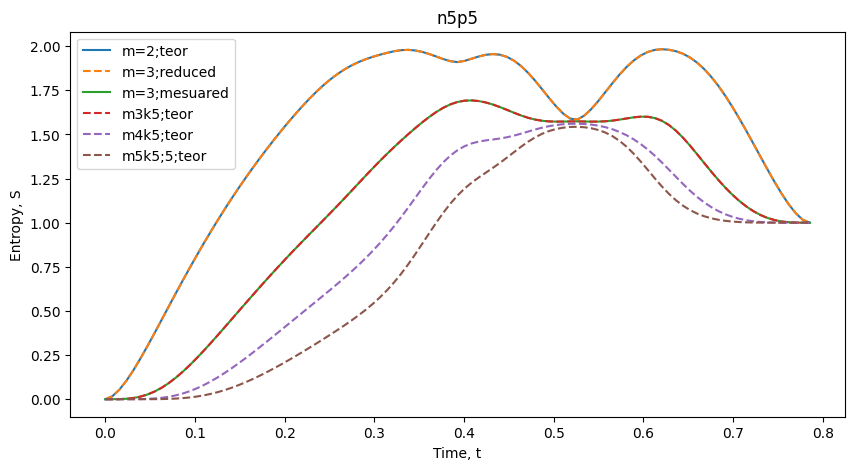

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, entropy_hzz_n2_teor, label=f"m=2;teor")
ax.plot(tspan, entropy_hzz_n3, "--", label=f"m={m};reduced")
ax.plot(tspan, entropy_hzz_n3_x, "-", label=f"m={m};mesuared")
# ax.plot(tspan, entropy_hzz_n3_open_x, "-k", label=f"m={m};open;mesuared")
for m_sites_, entropy_vn_span in entropy_vn_spans:
    label = f"m{m_sites_}k{';'.join(map(str, (n_bosons,) * (m_sites_ // 2 - ((m_sites_ + 1) % 2))))};teor"
    ax.plot(tspan, entropy_vn_span, "--", label=label)
ax.set_title(f"n{n_bosons}p{i_projection}")
ax.set_ylabel("Entropy, S")
ax.set_xlabel("Time, t")
ax.legend()